# Figure 5 - Rescue of an Intracellular Nanobody


This notebook replicates figures 5 and S6 that deal with using predictions from the pretrained model to design a series mutations in CDR1 and 2 of two nanobodies to improve their biophysical properties (fitness).

In **Figure 5**, we focus on NbSmo8 from [this paper](https://www.nature.com/articles/s41586-019-1355-4).
The general strategy is as follows:
 1. We use the LR model and CNN to generate perturbation scores for all possible single mutations in CDR1 and CDR2 of NbSmo8.
 2. Using this information, as well as the [crystal structure of NbSmo8](https://www.rcsb.org/structure/6o3c), we design a series of mutations in CDR1 and CDR2 that are though to improve the biophysical properties of the nanobody while maintaining its binding affinity.

In **Figure S6**, we apply the same workflow to NbCov8 from a campaign to isolate nanobodies that bind to the SARS-CoV-2 spike protein ([paper link](https://www.science.org/doi/10.1126/science.abe3255)).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
%matplotlib inline

from nabstab.datasets.classifier_dataset import pad_cdr2, pad_internal, NbStabilityDataset
from nabstab.utils import (
    load_model,
    plot_scores_cnn,
    plot_scores_lr,
    dms_redesign
)

from nabstab.constants import AA2INDEX

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
## Get the paths setup
from pathlib import Path
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

## Empirical Frequencies in Dataset

To help guide the choice of rescue mutants, we also want to get a sense for what is generally allowed at different positions

In [3]:
#helper function to get the empirical frequencies of different amino acids at different positions
training_datafile = data_dir / 'model_training_data' / 'ENN_train.csv'

save_file = data_dir / 'unseen_weights.npy'

if not save_file.exists():

    df = pd.read_csv(training_datafile)
    ds = NbStabilityDataset(df, AA2INDEX, cdr3_max_len=28)
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    sums = torch.zeros((len(AA2INDEX), ds.sequence_length))
    for s, _ in dl:
        oh = F.one_hot(s, len(AA2INDEX)).transpose(1,2)
        sums += oh.sum(dim=0)

    # There are 1,164,575 total sequences, only allow positions with at least 500 observations
    unseen_weights = sums < 1e2
    unseen_weights[:, 20:] = 0

    #save it
    np.save(save_file, unseen_weights.numpy())
else:
    unseen_weights = np.load(save_file)

## Load Models

In [4]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#load models
lrmodel = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

cnnmodel = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)

Using device: cpu


## Extract the CDR regions

In many cases, we can do a regex search. However, we need to be careful of potential mismatches along the flanking regions.

A safer approach is to first annotate the nanobody using ANARCI and then extract the regions that we used to build the model.

This can be accomplished with:

```bash
$ ANARCI -i nbs_to_opt.fasta -o nbs_to_opt --csv -s imgt --use_species alpaca --scheme aho
```

In [5]:
seqs_to_opt = {r.id: str(r.seq) for r in SeqIO.parse(data_dir / 'rescue_data' / 'nbs_to_opt.fasta', 'fasta')}

In [6]:
#read in anarci output
df = pd.read_csv(data_dir / 'rescue_data' / 'nbs_to_opt_H.csv')

cdr1_cols = list(filter(lambda x: x[:2] in [str(i) for i in range(28,39)], df.columns))
cdr2_cols = list(filter(lambda x: x[:2] in [str(i) for i in range(52,67)], df.columns))
cdr3_cols = list(filter(lambda x: x[:3] in [str(i) for i in range(105,118)], df.columns))
cdr1 = df[cdr1_cols].apply(lambda x: ''.join(x).replace('-', ''), axis=1)
cdr2 = df[cdr2_cols].apply(lambda x: ''.join(x).replace('-',''), axis=1)
cdr3 = df[cdr3_cols].apply(lambda x: ''.join(x).replace('-',''), axis=1)

#new df with data

opt_df = pd.DataFrame({
    'Id': df['Id'],
    'sequence': df['Id'].map(seqs_to_opt),
    'CDR1': cdr1,
    'CDR2': cdr2,
    'CDR3': cdr3
})

## Check the baseline scores

In [7]:
opt_df['cdr2_padded'] = opt_df.CDR2.apply(pad_cdr2)
opt_df['cdr3_padded'] = opt_df.CDR3.apply(lambda x: pad_internal(x, 28))
opt_df['padded_sequence'] = opt_df.CDR1 + opt_df.cdr2_padded + opt_df.cdr3_padded

In [8]:
smo8 = torch.tensor([AA2INDEX[aa] for aa in opt_df['padded_sequence'].values[0]]).unsqueeze(0)
smo8a1 = torch.tensor([AA2INDEX[aa] for aa in opt_df['padded_sequence'].values[1]]).unsqueeze(0)
cov8 = torch.tensor([AA2INDEX[aa] for aa in opt_df['padded_sequence'].values[2]]).unsqueeze(0)

### First, Logistic Regression

In [9]:
smo8_lr = lrmodel.predict(smo8.to(device), return_logits=True).item()
smo8a1_lr = lrmodel.predict(smo8a1.to(device), return_logits=True).item()
cov8_lr = lrmodel.predict(cov8.to(device), return_logits=True).item()

### Then, the CNN

In [10]:
smo8_cnn = cnnmodel.predict(smo8.to(device), return_logits=True).squeeze()
smo8a1_cnn = cnnmodel.predict(smo8a1.to(device), return_logits=True).squeeze()
cov8_cnn = cnnmodel.predict(cov8.to(device), return_logits=True).squeeze()

In [11]:
opt_df['LR'] = [smo8_lr, smo8a1_lr, cov8_lr]
opt_df['CNN'] = [smo8_cnn, smo8a1_cnn, cov8_cnn]

### Check the positional scores

The nice thing about the logistic regression is that we can easily extract the positional scores by looking at the coefficients.

In [12]:
lr_weights = lrmodel.classifier.linear.weight.detach().cpu().reshape(21, -1)
smo8_scores = torch.gather(lr_weights, 0, smo8)
smo8a1_scores = torch.gather(lr_weights, 0, smo8a1)
cov8_scores = torch.gather(lr_weights, 0, cov8)

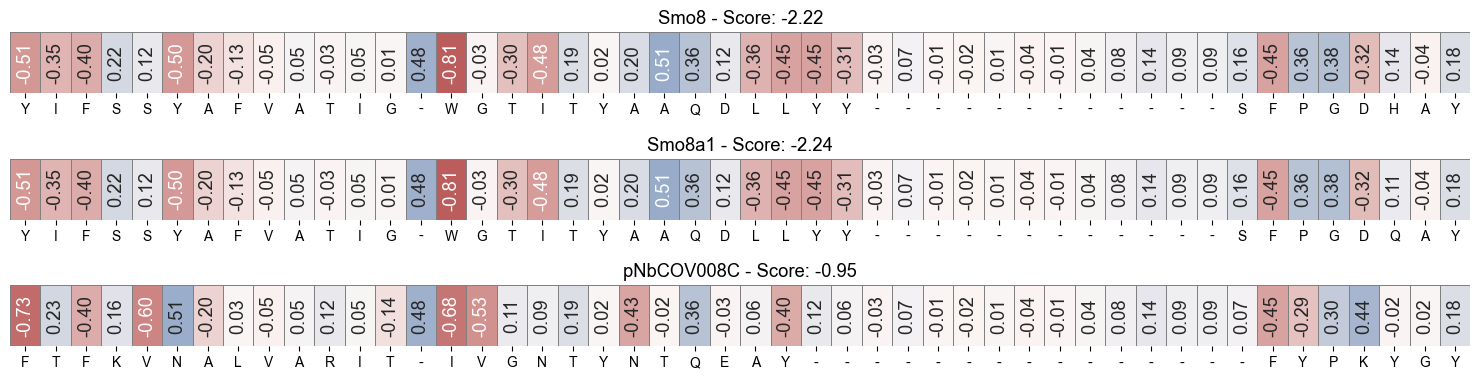

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 4))

sns.set_theme(style='white', font_scale=1.1)


sns.heatmap(smo8_scores, ax=ax[0], cmap='vlag_r', center=0, vmin = -1, vmax=1, cbar=False, xticklabels=opt_df['padded_sequence'].values[0], linecolor='gray', linewidth=0.5, annot=True, fmt='.2f', annot_kws={'rotation': 90})
sns.heatmap(smo8a1_scores, ax=ax[1], cmap='vlag_r', center=0, vmin = -1, vmax=1, cbar=False, xticklabels=opt_df['padded_sequence'].values[1], linecolor='gray', linewidth=0.5, annot=True, fmt='.2f', annot_kws={'rotation': 90})
sns.heatmap(cov8_scores, ax=ax[2], cmap='vlag_r', center=0, vmin = -1, vmax=1, cbar=False, xticklabels=opt_df['padded_sequence'].values[2], linecolor='gray', linewidth=0.5, annot=True, fmt='.2f', annot_kws={'rotation': 90})

ax[0].set_title(f'Smo8 - Score: {opt_df["LR"].values[0]:.2f}')
ax[1].set_title(f'Smo8a1 - Score: {opt_df["LR"].values[1]:.2f}')
ax[2].set_title(f'pNbCOV008C - Score: {opt_df["LR"].values[2]:.2f}')

for a in ax:
    a.set_yticks([])

fig.tight_layout()

fig.savefig(current_dir / 'figure_5_outputs' / 'lr_heatmaps.pdf', dpi=300)

#save the raw data
with open(current_dir / 'figure_5_outputs' / 'lr_heatmap_smo8.txt', 'w') as f:
    for pos, score in zip(opt_df.padded_sequence.values[0], smo8_scores.squeeze().numpy()):
        f.write(f'{pos} {score:.3f}\n')

with open(current_dir / 'figure_5_outputs' / 'lr_heatmap_nbcov8.txt', 'w') as f:
    for pos, score in zip(opt_df.padded_sequence.values[2], cov8_scores.squeeze().numpy()):
        f.write(f'{pos} {score:.3f}\n')

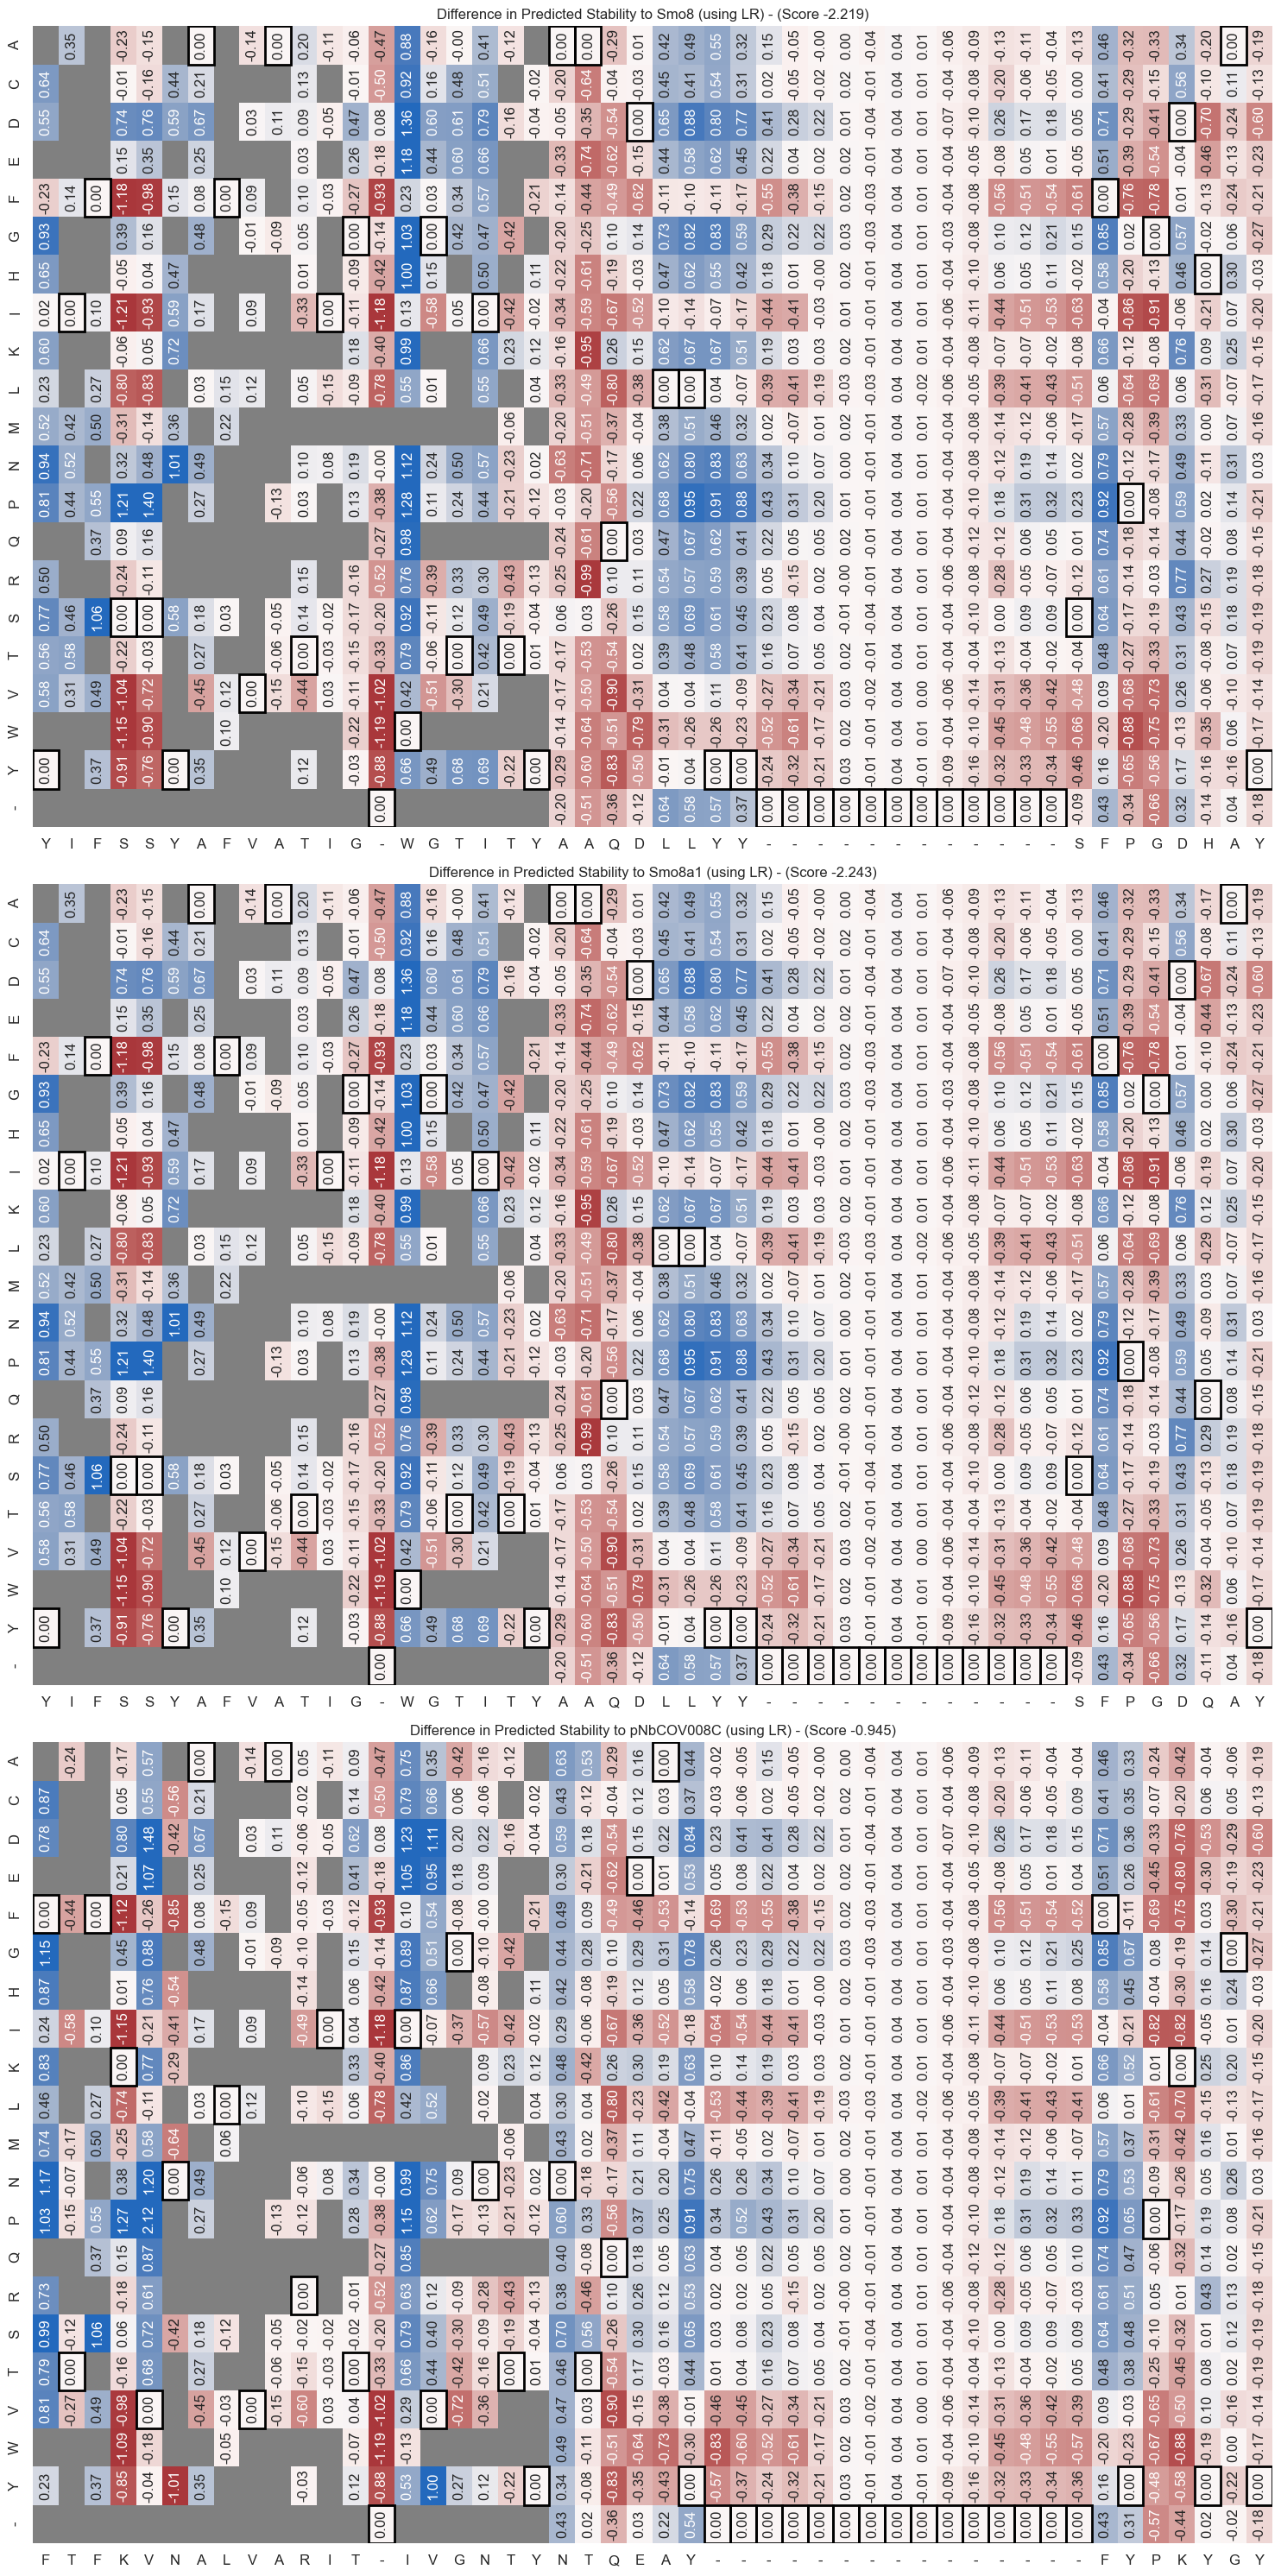

In [14]:
plot_scores_lr(
    lrmodel=lrmodel,
    sequence_tensors=[smo8, smo8a1, cov8],
    df = opt_df,
    unseen_weights= torch.tensor(unseen_weights),
    names=['Smo8', 'Smo8a1', 'pNbCOV008C'],
    filename=current_dir / 'figure_5_outputs' / 'lr_scores.pdf'
)

In [34]:
#save this raw data:
smo8_lr_map = lr_weights - smo8_scores
smo8a1_lr_map = lr_weights - smo8a1_scores
cov8_lr_map = lr_weights - cov8_scores

smo8_lr_map = smo8_lr_map * ~torch.tensor(unseen_weights)
smo8a1_lr_map = smo8a1_lr_map * ~torch.tensor(unseen_weights)
cov8_lr_map = cov8_lr_map * ~torch.tensor(unseen_weights)

#turn into a dataframe
smo8_df = pd.DataFrame(smo8_lr_map.numpy(), columns=[f'{opt_df.padded_sequence.values[0][i]}' for i in range(48)], index=AA2INDEX.keys())
smo8a1_df = pd.DataFrame(smo8a1_lr_map.numpy(), columns=[f'{opt_df.padded_sequence.values[1][i]}' for i in range(48)], index=AA2INDEX.keys())
cov8_df = pd.DataFrame(cov8_lr_map.numpy(), columns=[f'{opt_df.padded_sequence.values[2][i]}' for i in range(48)], index=AA2INDEX.keys())

#save the data
smo8_df.to_csv(current_dir / 'figure_5_outputs' / 'lr_map_smo8.csv')
smo8a1_df.to_csv(current_dir / 'figure_5_outputs' / 'lr_map_smo8a1.csv')
cov8_df.to_csv(current_dir / 'figure_5_outputs' / 'lr_map_cov8.csv')

## CNN

This is indirect, as we don't have a convenient lookup table. Instead, we can perform an in-silico DMS, in which we mutate each position to every other amino acid and then score the resulting sequences.

This is handled in the `dms_redesign` function from `utils`

In [15]:
smo8_cnn_dms = dms_redesign(
    cnnmodel= cnnmodel,
    sequence = smo8,
    device=device,
)

smo8a1_cnn_dms = dms_redesign(
    cnnmodel= cnnmodel,
    sequence = smo8a1,
    device=device,
)

cov8_cnn_dms = dms_redesign(
    cnnmodel= cnnmodel,
    sequence = cov8,
    device=device,
)

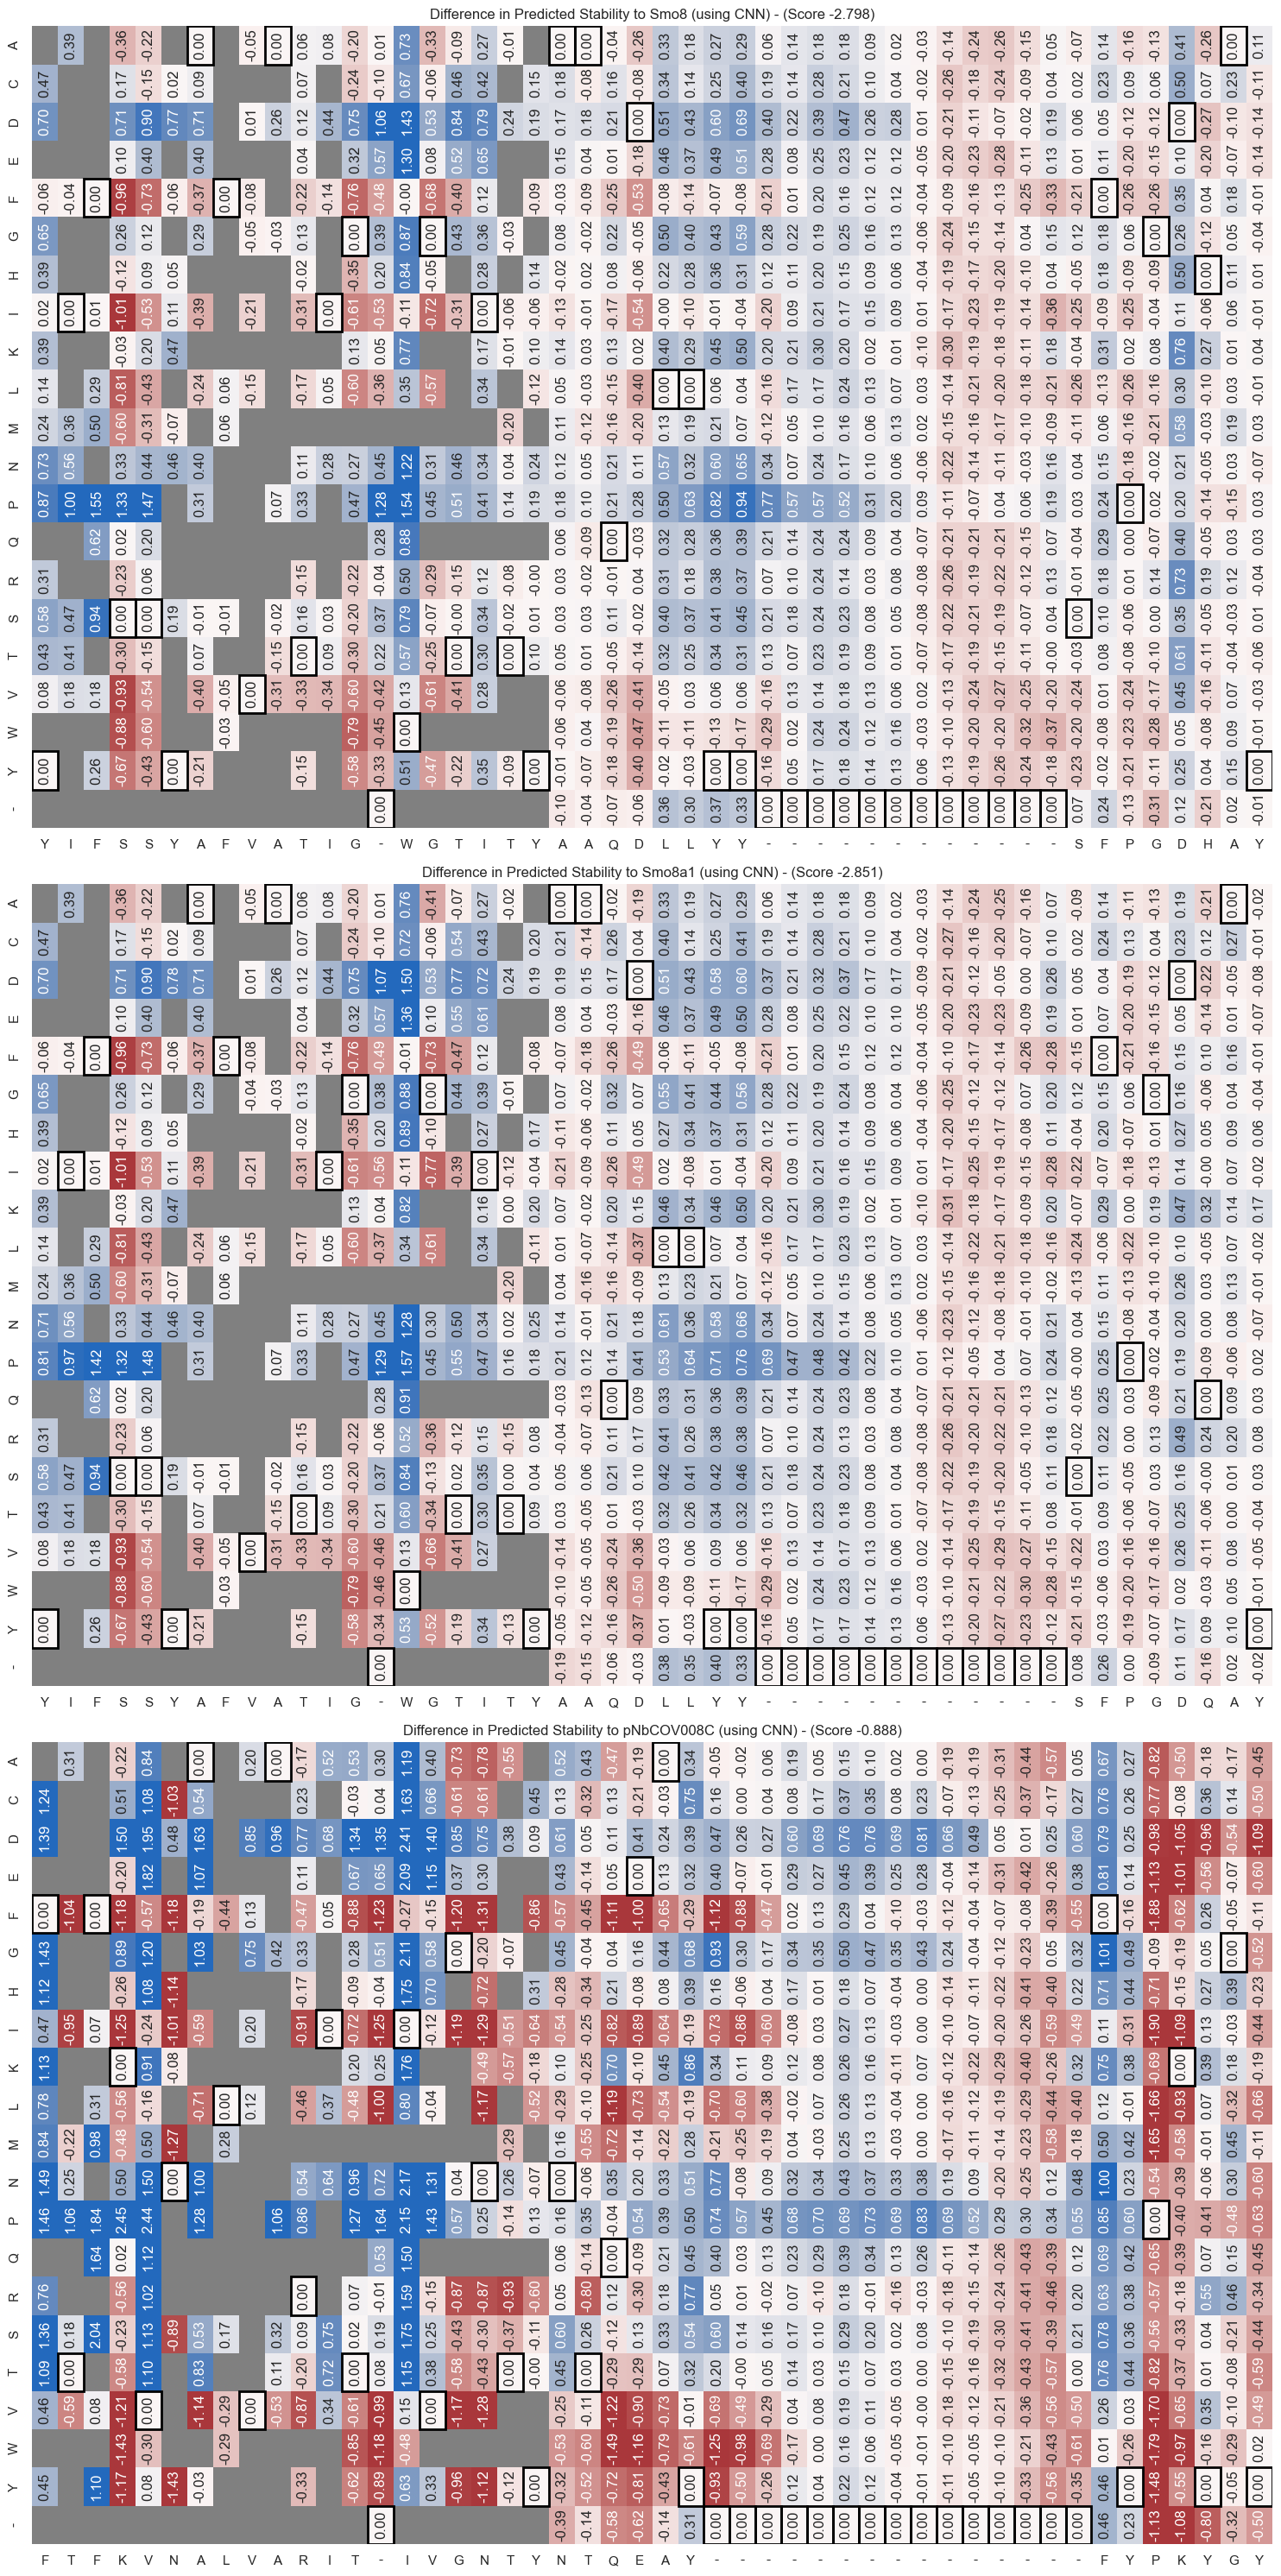

In [16]:
plot_scores_cnn(
    base_scores=[smo8_cnn, smo8a1_cnn, cov8_cnn],
    dms_scores=[smo8_cnn_dms, smo8a1_cnn_dms, cov8_cnn_dms],
    sequence_tensors=[smo8, smo8a1, cov8],
    df = opt_df,
    unseen_weights= torch.tensor(unseen_weights),
    names=['Smo8', 'Smo8a1', 'pNbCOV008C'],
    filename=current_dir / 'figure_5_outputs' / 'cnn_design_scores.pdf'
)

In [37]:
#save the data as csv files
smo8_cnn_map = smo8_cnn_dms - smo8_cnn
smo8a1_cnn_map = smo8a1_cnn_dms - smo8a1_cnn
cov8_cnn_map = cov8_cnn_dms - cov8_cnn

#zero out the positions/AAs that are not seen
smo8_masked = smo8_cnn_map.T * ~unseen_weights
smo8a1_masked = smo8a1_cnn_map.T * ~unseen_weights
cov8_masked = cov8_cnn_map.T * ~unseen_weights

smo8_dms_df = pd.DataFrame(smo8_masked, columns=[f'{opt_df.padded_sequence.values[0][i]}' for i in range(48)], index=AA2INDEX.keys())
smo8a1_dms_df = pd.DataFrame(smo8a1_masked, columns=[f'{opt_df.padded_sequence.values[1][i]}' for i in range(48)], index=AA2INDEX.keys())
cov8_dms_df = pd.DataFrame(cov8_masked, columns=[f'{opt_df.padded_sequence.values[2][i]}' for i in range(48)], index=AA2INDEX.keys())

In [38]:
smo8_dms_df.to_csv(current_dir / 'figure_5_outputs' / 'cnn_map_smo8.csv')
smo8a1_dms_df.to_csv(current_dir / 'figure_5_outputs' / 'cnn_map_smo8a1.csv')
cov8_dms_df.to_csv(current_dir / 'figure_5_outputs' / 'cnn_map_cov8.csv')

## Evaluate the fitness of the mutants

Here, we're just scoring the designed mutants (some of them have double mutations) using the CNN and LR models.

In [20]:
proposed_mutants = data_dir / 'rescue_data' / 'smo' / 'nbsmo_rescue_table.csv'
rescues = pd.read_csv(proposed_mutants)
#prep sequences
rescues['cdr2_padded'] = rescues.CDR2.apply(pad_cdr2)
rescues['cdr3_padded'] = rescues.CDR3.apply(lambda x: pad_internal(x, 28))
rescues['padded_sequence'] = rescues.CDR1 + rescues.cdr2_padded + rescues.cdr3_padded

numseqs = torch.tensor([[AA2INDEX[aa] for aa in seq] for seq in rescues['padded_sequence']])
numseqs = numseqs.to(device)

with torch.no_grad():
    preds_cnn = cnnmodel.predict(numseqs, return_logits=True)
    preds_lr = lrmodel.predict(numseqs, return_logits=True)

rescues['CNN_prediction'] = preds_cnn
rescues['LR_prediction'] = preds_lr

In [21]:
rescues

id     CDR1           CDR2              CDR3         type  \
0      NbSmo8  YIFSSYA   FVATIGWGTITY  AAQDLLYYSFPGDHAY       single   
1    NbSmo8-1  NIFSSYA   FVATIGWGTITY  AAQDLLYYSFPGDHAY       single   
2    NbSmo8-2  YSFSSYA   FVATIGWGTITY  AAQDLLYYSFPGDHAY       single   
3    NbSmo8-3  YIFSSNA   FVATIGWGTITY  AAQDLLYYSFPGDHAY       single   
4    NbSmo8-4  YIFSSYA   FVATIGYGTITY  AAQDLLYYSFPGDHAY       single   
5    NbSmo8-5  YIFSSYA   FVATIGWGDITY  AAQDLLYYSFPGDHAY       single   
6    NbSmo8-6  YIFSSYA   FVATIGWGTIDY  AAQDLLYYSFPGDHAY       single   
7    NbSmo8-7  NIFSSNA   FVATIGWGTITY  AAQDLLYYSFPGDHAY  combination   
8    NbSmo8-8  NIFSSNA  FVATIGWGTIDTY  AAQDLLYYSFPGDHAY  combination   
9    NbSmo8-9  NIFSSYA   FVATIGWGDDTY  AAQDLLYYSFPGDHAY  combination   
10  NbSmo8-10  NSFSSNA   FVATIGWGDDTY  AAQDLLYYSFPGDHAY  combination   

      cdr2_padded                   cdr3_padded  \
0   FVATIG-WGTITY  AAQDLLYY------------SFPGDHAY   
1   FVATIG-WGTITY  AAQDLLYY------------SFPGDHAY   
2   FVATIG-WGTITY  AAQDLLYY------------SFPGDHAY   
3   FVATIG-WGTITY  AAQDLLYY------------SFPGDHAY   
4   FVATIG-YGTITY  AAQDLLYY------------SFPGDHAY   
5   FVATIG-WGDITY  AAQDLLYY------------SFPGDHAY   
6   FVATIG-WGTIDY  AAQDLLYY------------SFPGDHAY   
7   FVATIG-WGTITY  AAQDLLYY------------SFPGDHAY   
8   FVATIGWGTIDTY  AAQDLLYY------------SFPGDHAY   
9   FVATIG-WGDDTY  AAQDLLYY------------SFPGDHAY   
10  FVATIG-WGDDTY  AAQDLLYY------------SFPGDHAY   

                                     padded_sequence  CNN_prediction  \
0   YIFSSYAFVATIG-WGTITYAAQDLLYY------------SFPGDHAY       -2.797918   
1   NIFSSYAFVATIG-WGTITYAAQDLLYY------------SFPGDHAY       -2.069574   
2   YSFSSYAFVATIG-WGTITYAAQDLLYY------------SFPGDHAY       -2.324409   
3   YIFSSNAFVATIG-WGTITYAAQDLLYY------------SFPGDHAY       -2.337011   
4   YIFSSYAFVATIG-YGTITYAAQDLLYY------------SFPGDHAY       -2.291645   
5   YIFSSYAFVATIG-WGDITYAAQDLLYY------------SFPGDHAY       -1.960177   
6   YIFSSYAFVATIG-WGTIDYAAQDLLYY------------SFPGDHAY       -2.558474   
7   NIFSSNAFVATIG-WGTITYAAQDLLYY------------SFPGDHAY       -1.667621   
8   NIFSSNAFVATIGWGTIDTYAAQDLLYY------------SFPGDHAY       -1.273947   
9   NIFSSYAFVATIG-WGDDTYAAQDLLYY------------SFPGDHAY        0.067481   
10  NSFSSNAFVATIG-WGDDTYAAQDLLYY------------SFPGDHAY        0.959227   

    LR_prediction  
0       -2.218660  
1       -1.274664  
2       -1.756632  
3       -1.213362  
4       -1.554479  
5       -1.604370  
6       -2.374509  
7       -0.269366  
8        0.338210  
9        0.133286  
10       1.600612

In [22]:
to_keep = ['id', 'CDR1', 'CDR2', 'CDR3', 'CNN_prediction', 'LR_prediction']

output_file = data_dir / 'rescue_data' / 'smo' / 'nbsmo_rescue_predictions.csv'
rescues[to_keep].to_csv(output_file, index=False)

### Compare to a known Nb for Smo

NbSmo2 is a known intracellular nanobody that, while lower affinity for the receptor, seems to have better biochemical properties. We can compare the designed mutants to this nanobody.

In [10]:
nbsmo2_sequence = 'QVQLQESGGGLVQAGGSLRLSCAASGSISDSDDMGWYRQAPGKEREFVATIGYGTTTNYADSVKGRFTISRDNAKNTVYLQMNSLKPEDTAVYYCAVSQDQIGPPYFYYYWGQGTQVTVSS'

#extract CDRS using Regex
import re
CDR1_PATTERN = '(?<=RLSCAASG).*?(?=MGWYRQA)'
CDR1_RE = re.compile(CDR1_PATTERN)
CDR2_PATTERN = '(?<=RQAPGKERE).*?(?=YADSVKGR)'
CDR2_RE = re.compile(CDR2_PATTERN)
CDR3_PATTERN = '(?<=EDTAVYYC).*?(?=WGQGTQ)'
CDR3_RE = re.compile(CDR3_PATTERN)

cdr1 = re.search(CDR1_RE, nbsmo2_sequence)
cdr2 = re.search(CDR2_RE, nbsmo2_sequence)
cdr3 = re.search(CDR3_RE, nbsmo2_sequence)

cdr1 = cdr1.group() if cdr1 else ''
cdr2 = cdr2.group() if cdr2 else ''
cdr3 = cdr3.group() if cdr3 else ''

cdr2_padded = pad_cdr2(cdr2)
cdr3_padded = pad_internal(cdr3, 28)

padded_sequence = cdr1 + cdr2_padded + cdr3_padded
numseq = torch.tensor([AA2INDEX[aa] for aa in padded_sequence]).unsqueeze(0).to(device)

with torch.no_grad():
    cnn_pred = cnnmodel.predict(numseq, return_logits=True)
    lr_pred = lrmodel.predict(numseq, return_logits=True)

print(f'CNN Prediction: {cnn_pred.item()}')
print(f'LR Prediction: {lr_pred.item()}')

CNN Prediction: 2.6142773628234863
LR Prediction: 3.788478136062622


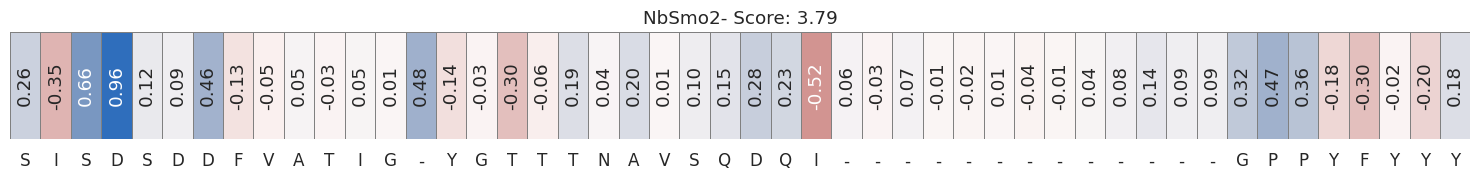

In [18]:
lr_weights = lrmodel.classifier.linear.weight.detach().cpu().reshape(21, -1)
smo2_scores = torch.gather(lr_weights, 0, numseq.cpu())

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

sns.set_theme(style='white', font_scale=1.1)

sns.heatmap(smo2_scores, ax=ax, cmap='vlag_r', center=0, vmin = -1, vmax=1, cbar=False, xticklabels=padded_sequence, linecolor='gray', linewidth=0.5, annot=True, fmt='.2f', annot_kws={'rotation': 90})

ax.set_title(f'NbSmo2- Score: {lr_pred.item():.2f}')
ax.set_yticks([])

fig.tight_layout()
fig.savefig(current_dir / 'figure_5_outputs' / 'lr_heatmap_nbsmo2.pdf', dpi=300)

#save the data as well
with open(current_dir / 'figure_5_outputs' / 'lr_heatmap_nbsmo2.txt', 'w') as f:
    for pos, score in zip(padded_sequence, smo2_scores.squeeze().numpy()):
        f.write(f'{pos} {score:.3f}\n')